# PFAM Classification Task

**Aim:**
- Classify protein family from amino acid sequence

**Overview:**
- Explore the dataset
    - Examine class distributions and other key statistics
    - Deal with class imbalance, and large size
- Define hypothesis
    - Can BERT-style embeddings enable few shot learning?
- Define method
- Define experiments
- Define model
    - Transformer
    - ProtCNN as baseline (can change to MLP)
- Train
- Results

## Imports

In [1]:
import pandas as pd
import glob

## Exploratory data analysis

### Load data
We first read in the train, val, test data to `pandas` dataframes

N.B. We could use the stratified sampling to avoid similarities between train and test sets

In [2]:
# Set filepaths to train, val, test splits
train_path = "data/train"
dev_path = "data/dev"
test_path = "data/test"

# Initialize the dataframes
train_df = pd.DataFrame()
dev_df = pd.DataFrame()
test_df = pd.DataFrame()

# Read in data
for filepath in glob.iglob(train_path + "/*"):
    train_df = pd.concat([train_df, pd.read_csv(filepath)], axis=0)
for filepath in glob.iglob(dev_path + "/*"):
    dev_df = pd.concat([dev_df, pd.read_csv(filepath)], axis=0)
for filepath in glob.iglob(test_path + "/*"):
    test_df = pd.concat([test_df, pd.read_csv(filepath)], axis=0)

In [3]:
train_df

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,EKR,R6QAS0_9FIRM/627-685,PF10371.9,.EEKKLVIPTNRPEMKDFVKNILHPIDHLHGDDLPVSKFV..DRAD...,EEKKLVIPTNRPEMKDFVKNILHPIDHLHGDDLPVSKFVDRADGVY...
1,DUF4042,B3MYB3_DROAN/365-542,PF13251.6,KVRISALHLLGSLAKNLPRRFLYGYWHILFPSG.......EHGATN...,KVRISALHLLGSLAKNLPRRFLYGYWHILFPSGEHGATNSHLLLLG...
2,Reg_prop,Q8EJN6_SHEON/296-320,PF07494.11,AQANMETLK..AILF...DKSG.LMWVGGSG,AQANMETLKAILFDKSGLMWVGGSG
3,DUF3880,M1WYU2_PSEP2/257-334,PF12996.7,WFVDNPHLILHHYTHPGTDNTAIFTYDAGNL.EPLRRKGFANTY.Y...,WFVDNPHLILHHYTHPGTDNTAIFTYDAGNLEPLRRKGFANTYYLP...
4,UPRTase,B6GYG1_PENRW/502-699,PF14681.6,AT.DRPAAKLLMTPMRDASI.SGSALRKVHGRVGFYLATELCT.QI...,ATDRPAAKLLMTPMRDASISGSALRKVHGRVGFYLATELCTQIMGL...
...,...,...,...,...,...
13370,Tub_N,F1RNI1_PIG/29-238,PF16322.5,RQRALLEQKQKKKRQEPL.MVQANADGR..PRSRRARQSE.........,RQRALLEQKQKKKRQEPLMVQANADGRPRSRRARQSEEQAPLVESY...
13371,Phospho_p8,A0A1X7VUV4_AMPQE/3-63,PF10195.9,HIYFDEYDY.FNFGSGFDKMFPDNKNTGHSKHKGYKLETQRYSPSG...,HIYFDEYDYFNFGSGFDKMFPDNKNTGHSKHKGYKLETQRYSPSGH...
13372,E3_binding,D5QEH1_KOMHA/126-161,PF02817.17,VFASPVAR.RLARLHEL....DLR..RV..G....G....S.GPRG...,VFASPVARRLARLHELDLRRVGGSGPRGRILRRDIE
13373,CDT1,W5MBI2_LEPOC/258-422,PF08839.11,LPYKYKMLAEMFRCLDTIVSILFNRSETATFAK.VKQGVQDMMH.....,LPYKYKMLAEMFRCLDTIVSILFNRSETATFAKVKQGVQDMMHKRF...


Note: Sequences are aligned to their family. However we are predicting the family, i.e. this is unknown.<br><br>
$\therefore$ we should not use `aligned_sequences`

In [4]:
all_dfs: dict[str, pd.DataFrame] = {"train": train_df, "dev": dev_df, "test": test_df}

In [5]:
for split, df in all_dfs.items():
    df.drop(columns=["aligned_sequence"], inplace=True)
    print(df.columns)

Index(['family_id', 'sequence_name', 'family_accession', 'sequence'], dtype='object')
Index(['family_id', 'sequence_name', 'family_accession', 'sequence'], dtype='object')
Index(['family_id', 'sequence_name', 'family_accession', 'sequence'], dtype='object')


Also, version number is irrelevant in `family_accession`. <br><br>
$\therefore$ we drop them.

In [6]:
for split, df in all_dfs.items():
    df["family_accession"] = df["family_accession"].apply(lambda x: x.split(".")[0])
train_df

,family_id,sequence_name,family_accession,sequence
0,EKR,R6QAS0_9FIRM/627-685,PF10371,EEKKLVIPTNRPEMKDFVKNILHPIDHLHGDDLPVSKFVDRADGVY...
1,DUF4042,B3MYB3_DROAN/365-542,PF13251,KVRISALHLLGSLAKNLPRRFLYGYWHILFPSGEHGATNSHLLLLG...
2,Reg_prop,Q8EJN6_SHEON/296-320,PF07494,AQANMETLKAILFDKSGLMWVGGSG
3,DUF3880,M1WYU2_PSEP2/257-334,PF12996,WFVDNPHLILHHYTHPGTDNTAIFTYDAGNLEPLRRKGFANTYYLP...
4,UPRTase,B6GYG1_PENRW/502-699,PF14681,ATDRPAAKLLMTPMRDASISGSALRKVHGRVGFYLATELCTQIMGL...
...,...,...,...,...
13370,Tub_N,F1RNI1_PIG/29-238,PF16322,RQRALLEQKQKKKRQEPLMVQANADGRPRSRRARQSEEQAPLVESY...
13371,Phospho_p8,A0A1X7VUV4_AMPQE/3-63,PF10195,HIYFDEYDYFNFGSGFDKMFPDNKNTGHSKHKGYKLETQRYSPSGH...
13372,E3_binding,D5QEH1_KOMHA/126-161,PF02817,VFASPVARRLARLHELDLRRVGGSGPRGRILRRDIE
13373,CDT1,W5MBI2_LEPOC/258-422,PF08839,LPYKYKMLAEMFRCLDTIVSILFNRSETATFAKVKQGVQDMMHKRF...


### Key statistics

#### Dataset split

In [7]:
n_train = train_df.shape[0]
n_dev = dev_df.shape[0]
n_test = test_df.shape[0]
n_total = n_train + n_dev + n_test
print(f"Train: {n_train} ({n_train/n_total*100:.1f}%)")
print(f"Dev: {n_dev} ({n_dev/n_total*100:.1f}%)")
print(f"Test: {n_test} ({n_test/n_total*100:.1f}%)")

Train: 1086741 (81.2%)
Dev: 126171 (9.4%)
Test: 126171 (9.4%)


$\implies$ Large proportion of data is in training set

#### Class distribution

In [8]:
for split, df in all_dfs.items():
    print(f"The number of unique families in {split} set is {len(df['family_accession'].unique())}")

The number of unique families in train set is 17929
The number of unique families in dev set is 13071
The number of unique families in test set is 13071


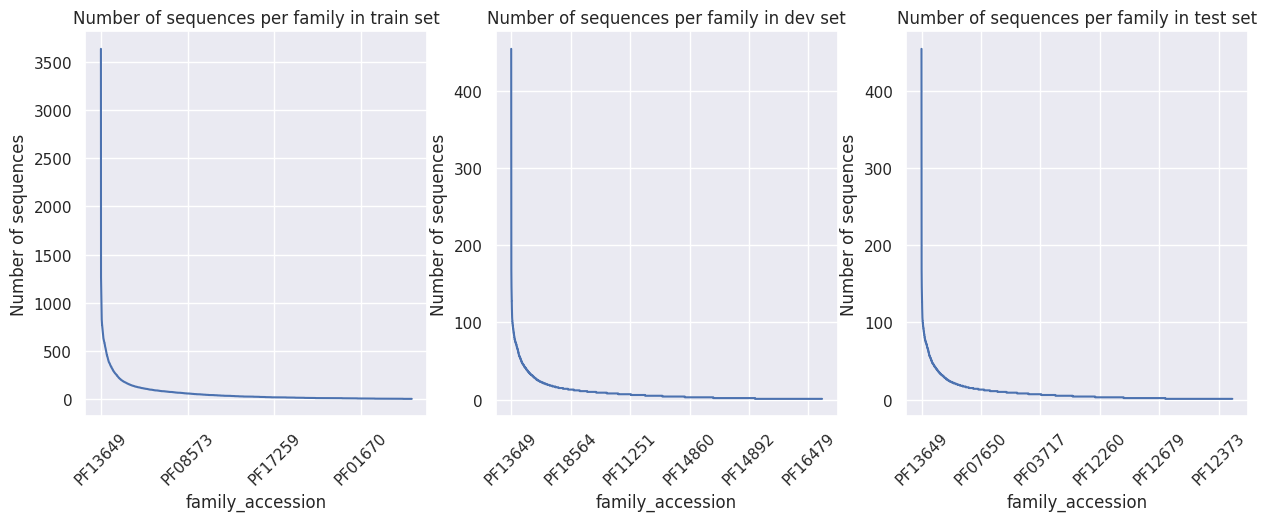

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

def plot_class_freqs(df, split):
    class_freqs = df["family_accession"].value_counts()
    class_freqs.plot(rot=45)
    # sns.barplot(x=class_freqs.index, y=class_freqs.values)
    plt.ylabel("Number of sequences")
    plt.title(f"Number of sequences per family in {split} set")

plt.subplots(1,3, figsize=(15,5))
for i, (split, df) in enumerate(all_dfs.items()):
    plt.subplot(1,3,i+1)
    plot_class_freqs(df, split)

We observe that there is a strong class imbalance. We also lack computational resources to utilise full dataset.

Let's select the top 64 classes.

/tmp/ipykernel_5816/1231399794.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = axis.set_xticklabels(family_names, rotation=90)
/tmp/ipykernel_5816/1231399794.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = axis.set_xticklabels(family_names, rotation=90)
/tmp/ipykernel_5816/1231399794.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = axis.set_xticklabels(family_names, rotation=90)


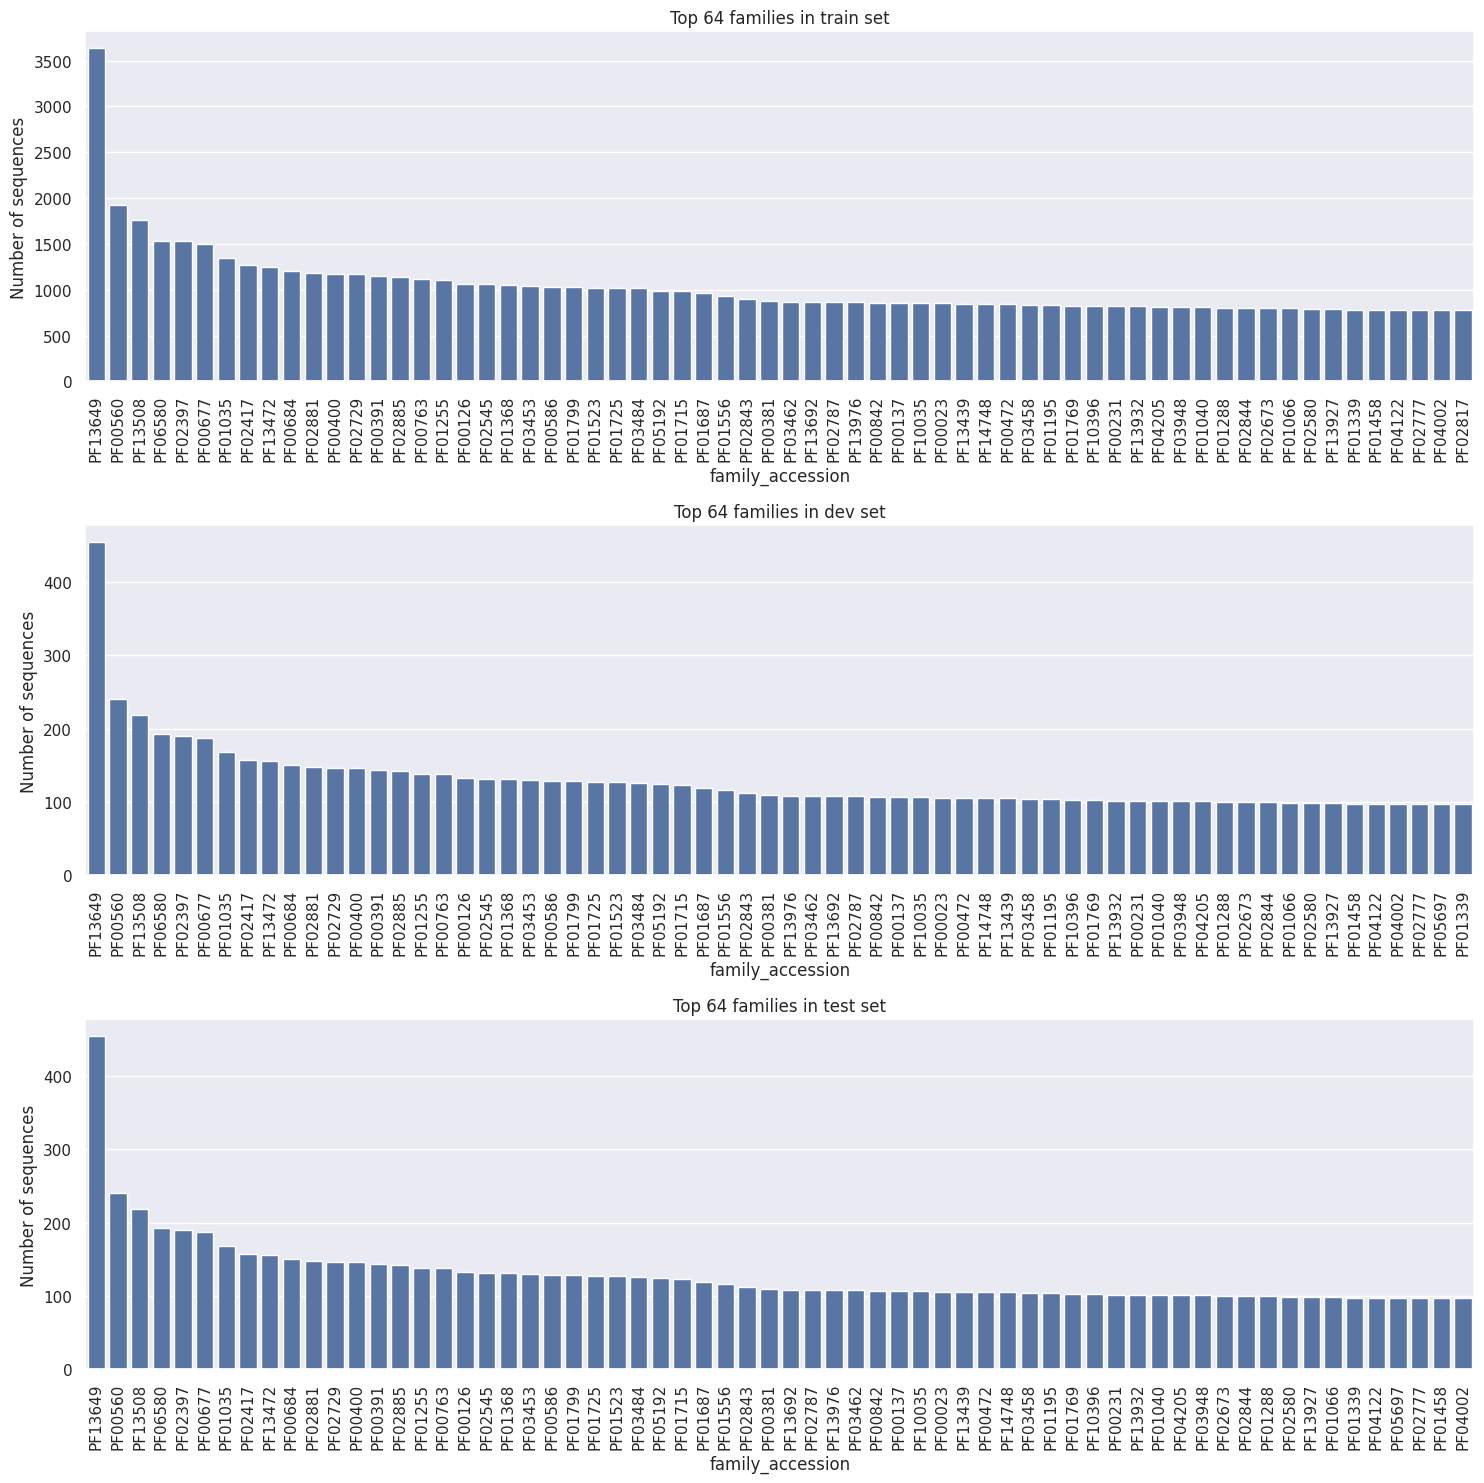

In [10]:
N = 64
def top_n_classes(df, N, axis):
    class_freqs = df["family_accession"].value_counts()
    family_names = class_freqs.index[:N]
    family_freqs = class_freqs.values[:N]
    sns.barplot(x=family_names, y=family_freqs, ax=axis)
    _ = axis.set_xticklabels(family_names, rotation=90)
    _ = axis.set_ylabel("Number of sequences")

fig, axes = plt.subplots(3,1, figsize=(15,15))
for i, (split, df) in enumerate(all_dfs.items()):
    top_n_classes(df, N, axes[i])
    _ = axes[i].set_title(f"Top {N} families in {split} set")
fig.tight_layout()
    

In [16]:
# Stack the dataframes
stacked_df = pd.concat(all_dfs.values(), axis=0)

# Select the top N classes across entire dataset
N = 64
class_freqs = stacked_df["family_accession"].value_counts()
top_N_classes = class_freqs.index[:N]

top_train_df = train_df[train_df["family_accession"].isin(top_N_classes)]
top_dev_df = dev_df[dev_df["family_accession"].isin(top_N_classes)]
top_test_df = test_df[test_df["family_accession"].isin(top_N_classes)]

all_dfs = {"train": top_train_df, "dev": top_dev_df, "test": top_test_df}

top_train_df.shape, top_dev_df.shape, top_test_df.shape

((66321, 4), (8256, 4), (8256, 4))

#### Input feature (Amino Acids) statistics

### Distribution of Sequence Lengths

In [20]:
# Retrieve raw sequence lengths for each split
all_seq_lengths = {}
for split, df in all_dfs.items():
    seq_lengths = df["sequence"].apply(len)
    all_seq_lengths[split] = seq_lengths
all_seq_lengths

{'train': 11       144
 19        66
 31       119
 50       178
 52       105
         ... 
 13242     95
 13287    117
 13314    122
 13344     80
 13368    300
 Name: sequence, Length: 66321, dtype: int64,
 'dev': 0         33
 19        89
 20        33
 50       181
 59        84
         ... 
 12552     77
 12562    227
 12568     86
 12586    120
 12594    226
 Name: sequence, Length: 8256, dtype: int64,
 'test': 9        122
 18        80
 33        39
 39        65
 61       290
         ... 
 12504     75
 12513    144
 12522     78
 12531     75
 12599     63
 Name: sequence, Length: 8256, dtype: int64}

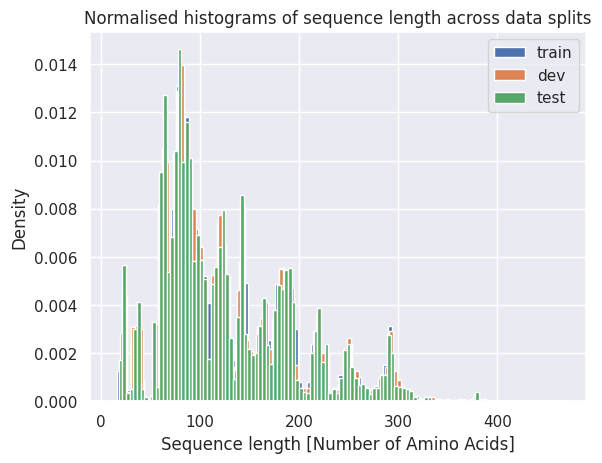

In [25]:
# Plot histograms of sequence lengths
plt.figure()
# def seq_len_hist(seq_lengths: pd.Series, split: str):
for split, seq_lengths in all_seq_lengths.items():
    plt.hist(seq_lengths, label=split, bins=100, density=True, )
_ = plt.legend()
_ = plt.title("Normalised histograms of sequence length across data splits")
_ = plt.xlabel("Sequence length [Number of Amino Acids]")
_ = plt.ylabel("Density")

- Similar distribution between each split which makes sense $\because$ randomly split

In [29]:
# Check percentage of sequences longer than 350
len_series = pd.concat(all_seq_lengths.values(), axis=0)
num_longer = (len_series > 350).sum()
print(f"There are {num_longer} sequences out of {len(len_series)} longer than 350 amino acids.")

There are 232 sequences out of 82833 longer than 350 amino acids.


- Looks like most sequences are less than 350 amino acids long
- We should pad and truncate to 350 to maintain constant sequence length for our model